In [2]:
import numpy as np
import os

import collections
import re

%matplotlib inline
import matplotlib.pyplot as plt

import keras
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, LSTM, Dropout, Input, TimeDistributed, Masking, Permute, Lambda, Flatten, Reshape, Embedding
from keras.optimizers import RMSprop, Adam

from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.utils import np_utils
from keras import backend as K

import tensorflow as tf

from mido import MetaMessage, Message, MidiFile, MidiTrack
import mido
import sys
import random
from random import randint

Using TensorFlow backend.


In [3]:
timeSignature = [4, 4]
numOfPitches = 88
noteRes = 8
#ticksPerNoteRes = int(midi_file.ticks_per_beat / noteRes)
#ticksPerNoteRes

In [4]:
def processMidiFile(midi_file, keyShift=0):
    global totalRunningDuration
    trackMessages = []
    runningDuration = totalRunningDuration
    for i, track in enumerate(midi_file.tracks):
        #runningDuration = totalRunningDuration
       
        for j, message in enumerate(track):
            if message.type == 'note_on' and message.velocity > 0:
                runningDuration += message.time
                #print(midiFilename, runningDuration)
                msg = {'type': message.type, 'note': message.note-keyShift, 'ticksPerNoteRes': int(midi_file.ticks_per_beat / noteRes), 'velocity': message.velocity, 'tick': message.time, 'runningTick': runningDuration, 'noteDurTick': 0, 'track': i}

                msgDuration = 0

                for k in range(j+1, len(track)-1, 1):
                    msgDuration += track[k].time
                    if (track[k].type == 'note_off' or track[k].velocity == 0) and track[k].note == message.note:
                        msg['noteDurTick'] = msgDuration
                        break

                trackMessages.append(msg)
                
    #totalRunningDuration = runningDuration
    trackMessages.sort(key=lambda x: x['runningTick'])
    totalRunningDuration = trackMessages[-1]['runningTick'] + trackMessages[-1]['noteDurTick']
    return trackMessages

In [5]:
def getNotePosition(key):
    keys = ['A', 'Bb', 'B', 'C', 'Db', 'D', 'Eb', 'E', 'F', 'Gb', 'G', 'Ab']
    sharpKeys = ['A', 'A#', 'B', 'C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#']
    keyStr = key[0]
    if len(key) > 1:
        if key[1] == 'b' or key[1] == '#':
            keyStr = keyStr + key[1]
        if key[1] == '#':
            keys = sharpKeys
    return keys.index(keyStr)

getNotePosition('F#')

9

In [6]:
midiFolder = 'midi'

mainKeyPosition = getNotePosition('C')
totalRunningDuration = 0
trackMessages = []
for midiFilename in os.listdir(midiFolder):
    print('Running file:', midiFolder+'/'+midiFilename)
    midi_file = MidiFile(midiFolder+'/'+midiFilename)
    
    metaKey = [msg.key for msg in midi_file.tracks[0] if msg.type == 'key_signature'][0]
    #print('key', metaKey)
    metaSign = [[msg.numerator, msg.denominator] for msg in midi_file.tracks[0] if msg.type == 'time_signature'][0]

    if metaSign != [4, 4]:
        print('Skipping file: ', midi_file)
        continue
    
    keyDistDiff = getNotePosition(metaKey) - mainKeyPosition
    midiMessages = processMidiFile(midi_file, keyDistDiff)
    trackMessages.extend(midiMessages)
    
trackMessages.sort(key=lambda x: x['runningTick'])
#trackMessages[1000:]
print('Total messages:', len(trackMessages))

Running file: barbiemidi/BarbieGirl.mid
Total messages: 979


In [7]:
trackMessages

[{'note': 64,
  'noteDurTick': 48,
  'runningTick': 0,
  'tick': 0,
  'ticksPerNoteRes': 12,
  'track': 1,
  'type': 'note_on',
  'velocity': 100},
 {'note': 60,
  'noteDurTick': 48,
  'runningTick': 0,
  'tick': 0,
  'ticksPerNoteRes': 12,
  'track': 1,
  'type': 'note_on',
  'velocity': 100},
 {'note': 64,
  'noteDurTick': 48,
  'runningTick': 0,
  'tick': 0,
  'ticksPerNoteRes': 12,
  'track': 1,
  'type': 'note_on',
  'velocity': 100},
 {'note': 69,
  'noteDurTick': 48,
  'runningTick': 0,
  'tick': 0,
  'ticksPerNoteRes': 12,
  'track': 1,
  'type': 'note_on',
  'velocity': 100},
 {'note': 65,
  'noteDurTick': 192,
  'runningTick': 0,
  'tick': 0,
  'ticksPerNoteRes': 12,
  'track': 1,
  'type': 'note_on',
  'velocity': 100},
 {'note': 62,
  'noteDurTick': 48,
  'runningTick': 0,
  'tick': 0,
  'ticksPerNoteRes': 12,
  'track': 1,
  'type': 'note_on',
  'velocity': 100},
 {'note': 59,
  'noteDurTick': 48,
  'runningTick': 0,
  'tick': 0,
  'ticksPerNoteRes': 12,
  'track': 1,
  't

In [8]:
lowerBoundNote = 21
upperBoundNote = lowerBoundNote + numOfPitches   #piano key range
totalPitches = upperBoundNote-lowerBoundNote
print(upperBoundNote-lowerBoundNote)

def getPitchIndex(pitch):
    if pitch < lowerBoundNote or pitch > upperBoundNote:
        return -1
    return int(pitch - lowerBoundNote)

88


In [9]:
def convertPitchToNote(pitchVal):
    octave = int(pitchVal / 12)
    notes = "C C#D D#E F F#G G#A A#B "
    notesIdx = "0 1 2 3 4 5 6 7 8 9 1011"
    note = notes[(pitchVal % 12) * 2:(pitchVal % 12) * 2 + 2]
    noteIdx = notesIdx[(pitchVal % 12) * 2:(pitchVal % 12) * 2 + 2]
    return note.strip(), octave

def convertNoteToPitch(noteId, octave):
    return noteId + octave * 12

print(convertPitchToNote(96))
print(convertNoteToPitch(5, 7))

('C', 8)
89


In [10]:
stateMat = []
for msg in trackMessages:
    notePos = getNotePosition(convertPitchToNote(msg['note'])[0])
    stateMat.append(notePos)

stateMat = np.array(stateMat)    
len(stateMat)

979

In [11]:
seq_length = 16
dataX = []
dataY = []

for i in range(0, len(stateMat) - seq_length, 1):
    seq_in = stateMat[i:i + seq_length]
    seq_out = stateMat[i + seq_length]
    dataX.append(seq_in)
    dataY.append(seq_out)
n_patterns = len(dataX)

dataX = np.array(dataX)
X = dataX / float(12)
dataY = np.array(dataY)
y = []
for yPitch in dataY:
    yOhe = np.zeros(12)
    yOhe[yPitch] = 1
    y.append(yOhe)
#y = np_utils.to_categorical(dataY, totalPitches+1)
y = np.array(y)

print(y.shape)
print("Total Patterns: ", n_patterns)

(963, 12)
Total Patterns:  963


In [12]:
y[2]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.])

In [13]:
batchSize = 16
trainLimit = int((X.shape[0] * 0.7)/batchSize)*batchSize
validOffset = batchSize-((X.shape[0] - trainLimit) % batchSize)

offsetId = randint(0, trainLimit)
print(offsetId)

trainX = X[0:trainLimit]
trainY = y[0:trainLimit]
validX = X[trainLimit-validOffset:]
validY = y[trainLimit-validOffset:]
#validX = np.append(validX, trainX[offsetId:offsetId+validOffset], axis=0)
#validY = np.append(validY, trainY[offsetId:offsetId+validOffset], axis=0)
trainX = trainX.reshape(trainX.shape[0], trainX.shape[1], 1)
validX = validX.reshape(validX.shape[0], validX.shape[1], 1)
print(trainX.shape)
print(trainY.shape)
print(validX.shape)
print(validY.shape)

619
(672, 16, 1)
(672, 12)
(304, 16, 1)
(304, 12)


In [14]:
inp = Input(shape=(trainX.shape[1], trainX.shape[2]))
print(inp.shape)
#x = Embedding(totalTickStates, 32)(inp)
x = LSTM(128, return_sequences=True)(inp)
x = Dropout(0.3)(x)
x = LSTM(64, return_sequences=False)(x)
x = Dropout(0.2)(x)
'''
x = LSTM(32)(x)
x = Dropout(0.2)(x)
'''
#x = Dense(8, activation='relu')(x)
output = Dense(y.shape[1], activation ='softmax')(x)

(?, 16, 1)


In [15]:
model = Model(inputs = inp, outputs=output )
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 16, 1)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 16, 128)           66560     
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 12)                780       
Total params: 116,748
Trainable params: 116,748
Non-trainable params: 0
_________________________________________________________________


In [16]:
optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [374]:
# define the checkpoint callback
filepath="checkpoints/7/midi-generation-simplified-weights-{epoch:02d}-{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
reduce_LR = ReduceLROnPlateau(monitor='val_loss',factor = 0.5, patience=3,cooldown=2, min_lr = 0.00001, mode='auto')
tensorboard = TensorBoard(log_dir=os.path.join('./', 'tensorboard-logs'), 
                                histogram_freq=0, 
                                write_graph=True, 
                                write_images=True)
callbacks_list = [checkpoint,reduce_LR]

In [35]:
model.load_weights("model/midi-generation-simplified-weights-477-1.1046.hdf5")

In [375]:
hist = model.fit(trainX, trainY, epochs=1000, batch_size=batchSize, verbose=1, validation_data=(validX, validY), callbacks=callbacks_list)

Train on 672 samples, validate on 304 samples
Epoch 1/1000
672/672 [==============================] - 5s - loss: 2.1320 - acc: 0.1711 - val_loss: 1.9876 - val_acc: 0.1776
Epoch 2/1000
672/672 [==============================] - 1s - loss: 1.9867 - acc: 0.1875 - val_loss: 1.9371 - val_acc: 0.1776
Epoch 3/1000
672/672 [==============================] - 1s - loss: 1.9713 - acc: 0.1905 - val_loss: 1.9290 - val_acc: 0.1776
Epoch 4/1000
672/672 [==============================] - 1s - loss: 1.9528 - acc: 0.1830 - val_loss: 1.9247 - val_acc: 0.1842
Epoch 5/1000
672/672 [==============================] - 1s - loss: 1.9626 - acc: 0.1667 - val_loss: 1.9224 - val_acc: 0.1776
Epoch 6/1000
672/672 [==============================] - 1s - loss: 1.9520 - acc: 0.1890 - val_loss: 1.9285 - val_acc: 0.1776
Epoch 7/1000
672/672 [==============================] - 1s - loss: 1.9485 - acc: 0.1905 - val_loss: 1.9147 - val_acc: 0.1776
Epoch 8/1000
672/672 [==============================] - 1s - loss: 1.9378 - acc

672/672 [==============================] - 1s - loss: 1.9031 - acc: 0.2009 - val_loss: 1.8486 - val_acc: 0.2533
Epoch 29/1000
672/672 [==============================] - 1s - loss: 1.9054 - acc: 0.2068 - val_loss: 1.8365 - val_acc: 0.2237
Epoch 30/1000
672/672 [==============================] - 1s - loss: 1.9269 - acc: 0.2202 - val_loss: 1.8282 - val_acc: 0.2500
Epoch 31/1000
672/672 [==============================] - 1s - loss: 1.9082 - acc: 0.2083 - val_loss: 1.8183 - val_acc: 0.2664
Epoch 32/1000
672/672 [==============================] - 1s - loss: 1.9112 - acc: 0.2143 - val_loss: 1.8029 - val_acc: 0.3059
Epoch 33/1000
672/672 [==============================] - 1s - loss: 1.9126 - acc: 0.2217 - val_loss: 1.8154 - val_acc: 0.2664
Epoch 34/1000
672/672 [==============================] - 1s - loss: 1.9070 - acc: 0.2188 - val_loss: 1.8950 - val_acc: 0.2993
Epoch 35/1000
672/672 [==============================] - 1s - loss: 1.9136 - acc: 0.2173 - val_loss: 1.8072 - val_acc: 0.2632
Epoch 

672/672 [==============================] - 1s - loss: 1.6288 - acc: 0.3720 - val_loss: 1.4120 - val_acc: 0.5691
Epoch 85/1000
672/672 [==============================] - 1s - loss: 1.6519 - acc: 0.3690 - val_loss: 1.4549 - val_acc: 0.5263
Epoch 86/1000
672/672 [==============================] - 1s - loss: 1.6460 - acc: 0.4033 - val_loss: 1.4195 - val_acc: 0.5296
Epoch 87/1000
672/672 [==============================] - 1s - loss: 1.6090 - acc: 0.3884 - val_loss: 1.3684 - val_acc: 0.5329
Epoch 88/1000
672/672 [==============================] - 1s - loss: 1.6086 - acc: 0.3720 - val_loss: 1.3580 - val_acc: 0.5329
Epoch 89/1000
672/672 [==============================] - 1s - loss: 1.6620 - acc: 0.3586 - val_loss: 1.6331 - val_acc: 0.5132
Epoch 90/1000
672/672 [==============================] - 1s - loss: 1.7220 - acc: 0.3616 - val_loss: 1.6010 - val_acc: 0.4342
Epoch 91/1000
672/672 [==============================] - 1s - loss: 1.7156 - acc: 0.3318 - val_loss: 1.5177 - val_acc: 0.5658
Epoch 

672/672 [==============================] - 1s - loss: 1.3824 - acc: 0.4881 - val_loss: 1.1650 - val_acc: 0.6579
Epoch 113/1000
672/672 [==============================] - 1s - loss: 1.3376 - acc: 0.5164 - val_loss: 1.1680 - val_acc: 0.6316
Epoch 114/1000
672/672 [==============================] - 1s - loss: 1.3915 - acc: 0.4688 - val_loss: 1.1707 - val_acc: 0.6184
Epoch 115/1000
672/672 [==============================] - 1s - loss: 1.3612 - acc: 0.4985 - val_loss: 1.1652 - val_acc: 0.6513
Epoch 116/1000
672/672 [==============================] - 1s - loss: 1.3464 - acc: 0.5089 - val_loss: 1.1521 - val_acc: 0.6184
Epoch 117/1000
672/672 [==============================] - 1s - loss: 1.3207 - acc: 0.5208 - val_loss: 1.1492 - val_acc: 0.6151
Epoch 118/1000
672/672 [==============================] - 1s - loss: 1.3292 - acc: 0.5119 - val_loss: 1.1370 - val_acc: 0.6283
Epoch 119/1000
672/672 [==============================] - 1s - loss: 1.2877 - acc: 0.5327 - val_loss: 1.1383 - val_acc: 0.6250

672/672 [==============================] - 1s - loss: 1.1171 - acc: 0.6071 - val_loss: 1.0242 - val_acc: 0.6645
Epoch 167/1000
672/672 [==============================] - 1s - loss: 1.1189 - acc: 0.5833 - val_loss: 1.0261 - val_acc: 0.6645
Epoch 168/1000
672/672 [==============================] - 1s - loss: 1.1499 - acc: 0.5863 - val_loss: 1.0260 - val_acc: 0.6711
Epoch 169/1000
672/672 [==============================] - 1s - loss: 1.1155 - acc: 0.5938 - val_loss: 1.0267 - val_acc: 0.6645
Epoch 170/1000
672/672 [==============================] - 1s - loss: 1.1182 - acc: 0.6101 - val_loss: 1.0256 - val_acc: 0.6645
Epoch 171/1000
672/672 [==============================] - 1s - loss: 1.1413 - acc: 0.5893 - val_loss: 1.0263 - val_acc: 0.6776
Epoch 172/1000
672/672 [==============================] - 1s - loss: 1.1471 - acc: 0.5848 - val_loss: 1.0237 - val_acc: 0.6743
Epoch 173/1000
672/672 [==============================] - 1s - loss: 1.1289 - acc: 0.5833 - val_loss: 1.0242 - val_acc: 0.6711

672/672 [==============================] - 1s - loss: 1.1101 - acc: 0.5997 - val_loss: 1.0192 - val_acc: 0.6809
Epoch 227/1000
672/672 [==============================] - 1s - loss: 1.1024 - acc: 0.6027 - val_loss: 1.0191 - val_acc: 0.6776
Epoch 228/1000
672/672 [==============================] - 1s - loss: 1.1141 - acc: 0.5848 - val_loss: 1.0190 - val_acc: 0.6776
Epoch 229/1000
672/672 [==============================] - 1s - loss: 1.1247 - acc: 0.6012 - val_loss: 1.0188 - val_acc: 0.6776
Epoch 230/1000
672/672 [==============================] - 1s - loss: 1.1298 - acc: 0.5744 - val_loss: 1.0190 - val_acc: 0.6809
Epoch 231/1000
672/672 [==============================] - 1s - loss: 1.1240 - acc: 0.5833 - val_loss: 1.0194 - val_acc: 0.6809
Epoch 232/1000
672/672 [==============================] - 1s - loss: 1.1084 - acc: 0.6042 - val_loss: 1.0198 - val_acc: 0.6776
Epoch 233/1000
672/672 [==============================] - 1s - loss: 1.1047 - acc: 0.6042 - val_loss: 1.0192 - val_acc: 0.6809

672/672 [==============================] - 1s - loss: 1.0774 - acc: 0.6086 - val_loss: 1.0165 - val_acc: 0.6809
Epoch 287/1000
672/672 [==============================] - 1s - loss: 1.0779 - acc: 0.6042 - val_loss: 1.0161 - val_acc: 0.6809
Epoch 288/1000
672/672 [==============================] - 1s - loss: 1.0846 - acc: 0.6116 - val_loss: 1.0158 - val_acc: 0.6809
Epoch 289/1000
672/672 [==============================] - 1s - loss: 1.1223 - acc: 0.5774 - val_loss: 1.0157 - val_acc: 0.6809
Epoch 290/1000
672/672 [==============================] - 1s - loss: 1.1116 - acc: 0.6116 - val_loss: 1.0156 - val_acc: 0.6809
Epoch 291/1000
672/672 [==============================] - 1s - loss: 1.0987 - acc: 0.6042 - val_loss: 1.0154 - val_acc: 0.6809
Epoch 292/1000
672/672 [==============================] - 1s - loss: 1.1003 - acc: 0.6131 - val_loss: 1.0152 - val_acc: 0.6809
Epoch 293/1000
672/672 [==============================] - 1s - loss: 1.1027 - acc: 0.6146 - val_loss: 1.0150 - val_acc: 0.6809

672/672 [==============================] - 1s - loss: 1.0991 - acc: 0.6086 - val_loss: 1.0126 - val_acc: 0.6809
Epoch 345/1000
672/672 [==============================] - 1s - loss: 1.0940 - acc: 0.6042 - val_loss: 1.0126 - val_acc: 0.6809
Epoch 346/1000
672/672 [==============================] - 1s - loss: 1.1252 - acc: 0.5863 - val_loss: 1.0126 - val_acc: 0.6776
Epoch 347/1000
672/672 [==============================] - 1s - loss: 1.0879 - acc: 0.5952 - val_loss: 1.0128 - val_acc: 0.6776
Epoch 348/1000
672/672 [==============================] - 1s - loss: 1.1081 - acc: 0.5952 - val_loss: 1.0126 - val_acc: 0.6809
Epoch 349/1000
672/672 [==============================] - 1s - loss: 1.0659 - acc: 0.5967 - val_loss: 1.0127 - val_acc: 0.6776
Epoch 350/1000
672/672 [==============================] - 1s - loss: 1.0805 - acc: 0.5982 - val_loss: 1.0126 - val_acc: 0.6776
Epoch 351/1000
672/672 [==============================] - 1s - loss: 1.1095 - acc: 0.6116 - val_loss: 1.0121 - val_acc: 0.6776

672/672 [==============================] - 1s - loss: 1.1003 - acc: 0.5878 - val_loss: 1.0105 - val_acc: 0.6809
Epoch 374/1000
672/672 [==============================] - 1s - loss: 1.0838 - acc: 0.6250 - val_loss: 1.0104 - val_acc: 0.6809
Epoch 375/1000
672/672 [==============================] - 1s - loss: 1.1011 - acc: 0.5938 - val_loss: 1.0107 - val_acc: 0.6809
Epoch 376/1000
672/672 [==============================] - 1s - loss: 1.0839 - acc: 0.5938 - val_loss: 1.0110 - val_acc: 0.6809
Epoch 377/1000
672/672 [==============================] - 1s - loss: 1.0961 - acc: 0.6190 - val_loss: 1.0106 - val_acc: 0.6809
Epoch 378/1000
672/672 [==============================] - 1s - loss: 1.1119 - acc: 0.6086 - val_loss: 1.0108 - val_acc: 0.6809
Epoch 379/1000
672/672 [==============================] - 1s - loss: 1.0803 - acc: 0.6310 - val_loss: 1.0112 - val_acc: 0.6809
Epoch 380/1000
672/672 [==============================] - 1s - loss: 1.0986 - acc: 0.6042 - val_loss: 1.0111 - val_acc: 0.6809

672/672 [==============================] - 1s - loss: 1.0729 - acc: 0.6012 - val_loss: 1.0093 - val_acc: 0.6809
Epoch 404/1000
672/672 [==============================] - 1s - loss: 1.0983 - acc: 0.5952 - val_loss: 1.0093 - val_acc: 0.6842
Epoch 405/1000
672/672 [==============================] - 1s - loss: 1.0685 - acc: 0.6205 - val_loss: 1.0092 - val_acc: 0.6809
Epoch 406/1000
672/672 [==============================] - 1s - loss: 1.0949 - acc: 0.6042 - val_loss: 1.0089 - val_acc: 0.6842
Epoch 407/1000
672/672 [==============================] - 1s - loss: 1.0683 - acc: 0.6071 - val_loss: 1.0087 - val_acc: 0.6809
Epoch 408/1000
672/672 [==============================] - 1s - loss: 1.0685 - acc: 0.6146 - val_loss: 1.0088 - val_acc: 0.6809
Epoch 409/1000
672/672 [==============================] - 1s - loss: 1.0851 - acc: 0.5938 - val_loss: 1.0088 - val_acc: 0.6809
Epoch 410/1000
672/672 [==============================] - 1s - loss: 1.0908 - acc: 0.6101 - val_loss: 1.0089 - val_acc: 0.6809

672/672 [==============================] - 1s - loss: 1.0894 - acc: 0.5848 - val_loss: 1.0082 - val_acc: 0.6842
Epoch 434/1000
672/672 [==============================] - 1s - loss: 1.1033 - acc: 0.5967 - val_loss: 1.0080 - val_acc: 0.6842
Epoch 435/1000
672/672 [==============================] - 1s - loss: 1.0745 - acc: 0.6190 - val_loss: 1.0079 - val_acc: 0.6842
Epoch 436/1000
672/672 [==============================] - 1s - loss: 1.1069 - acc: 0.5759 - val_loss: 1.0078 - val_acc: 0.6809
Epoch 437/1000
672/672 [==============================] - 1s - loss: 1.0641 - acc: 0.5997 - val_loss: 1.0077 - val_acc: 0.6842
Epoch 438/1000
672/672 [==============================] - 1s - loss: 1.0655 - acc: 0.6086 - val_loss: 1.0077 - val_acc: 0.6809
Epoch 439/1000
672/672 [==============================] - 1s - loss: 1.0947 - acc: 0.6146 - val_loss: 1.0078 - val_acc: 0.6809
Epoch 440/1000
672/672 [==============================] - 1s - loss: 1.1038 - acc: 0.6012 - val_loss: 1.0078 - val_acc: 0.6809

672/672 [==============================] - 1s - loss: 1.0879 - acc: 0.6042 - val_loss: 1.0062 - val_acc: 0.6842
Epoch 462/1000
672/672 [==============================] - 1s - loss: 1.0975 - acc: 0.6042 - val_loss: 1.0059 - val_acc: 0.6842
Epoch 463/1000
672/672 [==============================] - 1s - loss: 1.0881 - acc: 0.6101 - val_loss: 1.0061 - val_acc: 0.6842
Epoch 464/1000
672/672 [==============================] - 1s - loss: 1.0920 - acc: 0.5923 - val_loss: 1.0056 - val_acc: 0.6842
Epoch 465/1000
672/672 [==============================] - 1s - loss: 1.1023 - acc: 0.6086 - val_loss: 1.0052 - val_acc: 0.6842
Epoch 466/1000
672/672 [==============================] - 1s - loss: 1.1289 - acc: 0.5893 - val_loss: 1.0051 - val_acc: 0.6842
Epoch 467/1000
672/672 [==============================] - 1s - loss: 1.1047 - acc: 0.6042 - val_loss: 1.0052 - val_acc: 0.6842
Epoch 468/1000
672/672 [==============================] - 1s - loss: 1.0660 - acc: 0.6086 - val_loss: 1.0052 - val_acc: 0.6842

KeyboardInterrupt: 

In [380]:
model.save('lstm128-dropout03-lstm64-dropout02-batch16-seqlength16.model')

In [136]:
def plot_train(hist):
    h = hist.history
    if 'acc' in h:
        meas='acc'
        loc='lower right'
    else:
        meas='loss'
        loc='upper right'
    plt.plot(hist.history[meas])
    plt.plot(hist.history['val_'+meas])
    plt.title('model '+meas)
    plt.ylabel(meas)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc=loc)
    

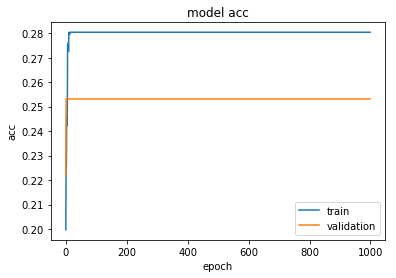

In [253]:
plot_train(hist)

In [20]:
model = load_model('model/lstm128-dropout03-lstm64-dropout02-batch16-seqlength16.model')

In [39]:
# pick a random seed
start = np.random.randint(0, len(dataX)-1)
pattern = dataX[start]
seed = dataX[start]
print("Seed pattern:", seed)

Seed pattern: [ 3  8 10  2  5 10  2  5 10  2  5 10  5  8  0  3]


In [40]:
generatedSeq = []

In [41]:
if len(generatedSeq) > 0:
    pattern = np.array(generatedSeq[-seq_length:])
generatedStateMat = []
print(pattern.shape)
for i in range(1000):
    x = np.reshape(pattern, (1, len(pattern), 1))
    x = x / float(12)
    prediction = model.predict(x, verbose=0)
    predictedTick = np.argmax(prediction)
    #print(len(prediction))
    
    #pitchMat = getStateFromTickId(predictedTick)
    #generatedStateMat.append(pitchMat)
    
    pattern = np.append(pattern, predictedTick)
    generatedSeq.append(predictedTick)
    pattern = pattern[1:len(pattern)]
    
    
print('Generated Sequence:', generatedSeq)


print(len(generatedSeq))



(16,)
Generated Sequence: [8, 0, 3, 7, 0, 3, 7, 0, 3, 7, 0, 3, 7, 0, 8, 7, 5, 8, 0, 3, 2, 0, 3, 2, 7, 10, 2, 3, 10, 5, 3, 7, 0, 3, 2, 0, 5, 2, 3, 7, 0, 3, 5, 0, 3, 7, 0, 3, 2, 0, 5, 0, 3, 5, 7, 0, 2, 7, 0, 3, 7, 0, 8, 10, 0, 5, 7, 5, 3, 7, 0, 8, 7, 0, 8, 10, 0, 10, 8, 3, 10, 9, 0, 10, 10, 0, 5, 7, 3, 10, 8, 0, 3, 10, 0, 3, 10, 0, 3, 10, 0, 3, 7, 5, 0, 10, 0, 3, 7, 0, 3, 7, 0, 8, 0, 3, 8, 0, 3, 7, 3, 3, 2, 0, 10, 2, 5, 10, 5, 3, 2, 7, 0, 3, 7, 0, 3, 10, 0, 3, 7, 5, 10, 0, 3, 10, 0, 10, 2, 5, 10, 2, 3, 10, 2, 5, 0, 5, 10, 2, 3, 7, 0, 3, 7, 0, 3, 10, 0, 3, 7, 0, 3, 7, 0, 5, 7, 0, 8, 0, 5, 8, 0, 3, 2, 0, 3, 2, 0, 10, 0, 3, 10, 5, 5, 5, 3, 0, 2, 10, 0, 7, 10, 0, 3, 7, 5, 7, 10, 0, 5, 7, 0, 8, 7, 5, 3, 10, 0, 3, 7, 0, 3, 7, 0, 3, 9, 0, 5, 7, 5, 3, 7, 0, 3, 7, 0, 3, 7, 0, 8, 0, 5, 10, 0, 3, 7, 0, 3, 2, 0, 10, 2, 5, 10, 5, 3, 3, 10, 0, 3, 7, 0, 8, 10, 5, 3, 7, 5, 3, 10, 9, 3, 8, 0, 8, 7, 0, 5, 10, 0, 3, 7, 0, 10, 7, 0, 3, 7, 5, 10, 8, 3, 5, 7, 3, 8, 7, 5, 3, 10, 0, 3, 7, 5, 10, 10, 5, 3, 3, 7,

In [44]:
outfile = MidiFile()

track = MidiTrack()
outfile.tracks.append(track)
track.append(Message('program_change', channel=0, program=0, time=0))

for notePos in generatedSeq:
    track.append(Message('note_on', note=notePos+6*12, velocity=np.random.randint(55, 128, size=1)[0], time=220))


outfile.save('results/generated_test10.mid')
